# CS1090A Introduction to Data Science

## Section 4: Polynomial Regression, Regularization, and Cross Validation

**Harvard University**<br/>
**Fall 2025**<br/>
**Instructors**: Pavlos Protopapas and Kevin Rader<br/>
**Preceptor**: Chris Gumb
<hr style='height:2px'>

In [1]:
# Data and Stats packages
import numpy as np
import pandas as pd

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

# Intelligence packages
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder

In [2]:
import sys
import os

if 'google.colab' in sys.modules:
    !curl -L "https://drive.google.com/uc?export=download&id=1nUY21Ra9hTCiqpum6bg9JYjGox7JuwZA" -o /content/Data.zip
    !unzip -o /content/Data.zip -d /content
elif not os.path.exists('Data'):
    !curl -L "https://drive.google.com/uc?export=download&id=1nUY21Ra9hTCiqpum6bg9JYjGox7JuwZA" -o Data.zip
    !unzip -o Data.zip
    !rm Data.zip

### Contents:
TOTAL 75 mins
* EDA & Feature Engineering (15 min)
* Polynomial Regression & Hyperparameter Tuning (15 min)
* Cross-Validation for Robust Model Selection (20 min)
* Regularization for Overfitting (25 min)
  * Ridge (L2) and Lasso (L1)
  * Visualizing Model Performance and Coefficients

<a id=intro></a>

## Question - Can we predict the "market value" of prospective players in the *Fantasy Premier League* dataset?
![trent](https://drive.google.com/uc?id=1B4drp0SEHM_9hXtzlyszak_fTIvlecxe)


<p style="text-align:right"><font size="1"; text-align='right'>(Image: Trent Alexander-Arnold https://www.premierleague.com/news/2766220)</font></p>


### Story
Once upon a time, the Football Association gave us a dataset and asked us to help them predict the <b>market value</b> of prospective players.

### The dataset
The dataset includes data up to 2017, and was created by [Shubham Maurya](https://www.kaggle.com/mauryashubham/linear-regression-to-predict-market-value/data) who used a variety of sources, including *transfermrkt.com* and *Fantasy Premier League (FPL)*, and a variety of methods, including scraping.
Each observation is a collection of facts about players in the English Premier League.

---

`name`             : Name of the player  
`club`             : Club of the player  
`age`              : Age of the player  
`position`         : The usual position on the pitch  
`position_cat`     : 1 for attackers, 2 for midfielders, 3 for defenders, 4 for goalkeepers   
`page_views`       : Average daily Wikipedia page views from September 1, 2016 to May 1, 2017  
`fpl_points`       : FPL points accumulated over the previous season (https://www.premierleague.com/news/2174909)<BR>
`region`           : 1 for England, 2 for EU, 3 for Americas, 4 for Rest of World  
`nationality`      : Player's nationality <BR>
`new_signing`      : Whether a new signing for 2017/18 (till 20th July)  
`new_foreign`      : Whether a new signing from a different league, for 2017/18 (till 20th July)  
`club_id`          : a numerical version of the Club feature
  
---

### Our goal
To construct and fit a model that predicts the players' `market value` using all or part of the features in the given data.

### Our return variable

`market_value`: As on *transfermrkt.com* on July 20th, 2017 in £M (British pounds)

## 1 - EDA, preliminary feature selection and engineering

### Import the data

In [3]:
df = pd.read_csv("Data/league_data.csv")
df.describe(include="all").T # All columns of the input (including categorical variables) will be included in the output.

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
name,460,460,Alexis Sanchez,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
club,460,20,Arsenal,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,460.0,NaN,NaN,NaN,26.81087,3.964039,17.0,24.0,27.0,30.0,38.0
position,460,13,CB,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
position_cat,460.0,NaN,NaN,NaN,2.178261,1.000417,1.0,1.0,2.0,3.0,4.0
market_value,460.0,NaN,NaN,NaN,11.018587,12.269941,0.05,3.0,7.0,15.0,75.0
page_views,460.0,NaN,NaN,NaN,764.6,932.652322,3.0,219.75,460.0,900.0,7664.0
fpl_points,460.0,NaN,NaN,NaN,57.336957,53.169454,0.0,5.0,51.0,94.0,264.0
region,460.0,NaN,NaN,NaN,1.993478,0.957689,1.0,1.0,2.0,2.0,4.0
nationality,460,61,England,156,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Any missing values?

In [4]:
df.isnull().sum()

name            0
club            0
age             0
position        0
position_cat    0
market_value    0
page_views      0
fpl_points      0
region          0
nationality     0
new_foreign     0
club_id         0
new_signing     0
dtype: int64

Nope.

### Features selection and some data cleaning
    
This should be a preliminary check for obvious features to include or excude.

> **Probing into the variables.**
>- `name` should not affect the market values.  
>- `club`, `age`, `position`, `position_cat`, `page_views`, `fpl_points`, `region`, `nationality`,`new_signing`, `new_foreign`, and `club_id` are *likely* to affect the market values.
>- `position` and `position_cat` may contain similar information.
>- `region`, `nationality`, and `new_foreign` and may contain similar information.
>- `club` and `club_id` may contain similar information.

#### `position` vs `position_cat`

In [5]:
# How many unique positions are there?
df.position.unique()

array(['LW', 'AM', 'GK', 'RW', 'CB', 'RB', 'CF', 'LB', 'DM', 'RM', 'CM',
       'SS', 'LM'], dtype=object)

If we use all these positions, too many new features will be generated after one-hot encoding.

> **Spoiler alert:** Too many features may not be too constructive to models.

We can simply use `position_cat`, which groups different specific positions into general ones: 1. attackers, 2. midfielder, 3. defender, and 4. goalkeeper.

In [6]:
# What is the relationship between the `position_cat` and `position` features?
df.groupby(['position_cat']).agg({'position': np.unique})

,position
position_cat,
1,"[AM, CF, LW, RB, RW, SS]"
2,"[CM, DM, LM, RM]"
3,"[CB, LB, RB]"
4,[GK]


#### `region` vs `nationality`

In [7]:
# Similarly, what is the relationship between `region` and `nationality`?
regions = df.groupby(['region']).agg({'nationality' : np.unique})
regions

,nationality
region,
1,"[England, Wales]"
2,"[Argentina, Austria, Belgium, Bosnia, Cameroon..."
3,"[Argentina, Bermuda, Brazil, Canada, Chile, Co..."
4,"[Algeria, Armenia, Australia, Benin, Cameroon,..."


Some nationality is included in multiple regions (e.g. Argentina). Let's find all such nationality.

In [8]:
for i in regions.index:
    region_a = set(regions.loc[i].values[0])
    for j in regions.index:
        region_b = set(regions.loc[j].values[0])
        if j > i:
            intersection = set.intersection(region_a, region_b)
            if len(intersection) > 0:
                print(f'Nationality occurs in both Region {i} and {j}:, {intersection}')

Nationality occurs in both Region 1 and 2:, {'England', 'Wales'}
Nationality occurs in both Region 2 and 3:, {'Argentina'}
Nationality occurs in both Region 2 and 4:, {'Cameroon'}
Nationality occurs in both Region 3 and 4:, {'United States'}


Let's clean up the regions by including the same nationality in ***one and the same*** region, generating a new feature called `region_organized`.

In [9]:
from Data.helper import reorganize_regions # A function to strictly rearrange the region according to nationality

# Create 'region_organized' feature
df['region_organized'] = df[['region', 'nationality']].apply(reorganize_regions, axis=1)

# Create 'big_six' feature
big_six = ['Arsenal', 'Chelsea','Liverpool', 'Manchester+City','Manchester+United', 'Tottenham']
df['big_six'] = df.club.isin(big_six).astype(int)

df.head()

,name,club,age,position,position_cat,market_value,page_views,fpl_points,region,nationality,new_foreign,club_id,new_signing,region_organized,big_six
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,264,3,Chile,0,1,0,3,1
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,167,2,Germany,0,1,0,2,1
2,Petr Cech,Arsenal,35,GK,4,7.0,1529,134,2,Czech Republic,0,1,0,2,1
3,Theo Walcott,Arsenal,28,RW,1,20.0,2393,122,1,England,0,1,0,1,1
4,Laurent Koscielny,Arsenal,31,CB,3,22.0,912,121,2,France,0,1,0,2,1


> **Mini invitation (Feel free to skip)**: If curious, please study (or reflect on) what `pandas.DataFrame.apply()` is doing at [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html). If not trusting us, feel free to see what `reorganize_regions()` from `Data/helper.py` is doing.

> **Question:** Is being in the *big six* affect market value?

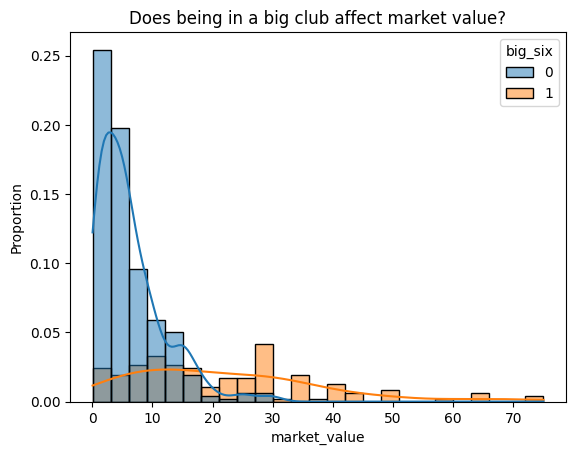

In [10]:
ax = sns.histplot(data=df, x='market_value', hue='big_six', stat='proportion', kde=True)
ax.set_title("Does being in a big club affect market value?");

 ### Train-test split (with stratification)

![test](https://drive.google.com/uc?id=1mgsEfUb87mTt3NXwsIZdzfxVyPSseipP)

*Just for now*, let us first divide the dataset into train and test sets, as usual.

We want to make sure that the training and test data have appropriate representation of certain variables; it would be bad for the training data or the test data to entirely miss a region, for example. This is especially important when some features are underrepresented (our data is **imbalanced**). To see the numbers in each category:

In [11]:
print(df['region_organized'].value_counts().sort_index())

region_organized
1    168
2    193
3     43
4     56
Name: count, dtype: int64


We can fix this issue with statification to make sure the splitted datasets have similar distribution in terms of `region_organized`. To stratify, we set the parameter `stratify = df['region_organized']`

> **Note:** This will not work if the dataset contains missing data.

In [12]:
# Designate predictor variables
categorical_cols = ['position_cat', 'new_signing', 'region_organized', 'big_six']
numerical_cols = ['page_views', 'fpl_points', 'age']
ordinal_cols = [] # we do not have any

# Designate response variables
response = 'market_value'
y = df[response]
x = df.drop(response, axis=1)

In [13]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
                                            x, y,
                                            random_state=109,
                                            stratify=df['region_organized'],
                                            test_size = 0.2,
                                            )
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((368, 14), (92, 14), (368,), (92,))

> **Question:** We used `stratify=df['region_organized']` when splitting our data. What problem does stratification solve, especially for a feature like `region_organized` where some categories have very few samples? What might happen if we didn't stratify?

## 2 - Feature Engineering

 ### Extract the chosen variables

In [14]:
print(f'Chosen categorical predictor variables: {categorical_cols}')
print(f'Chosen numerical predictor variables: {numerical_cols}')
cols = categorical_cols + numerical_cols

X_train = x_train[cols].copy()
X_test = x_test[cols].copy()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

Chosen categorical predictor variables: ['position_cat', 'new_signing', 'region_organized', 'big_six']
Chosen numerical predictor variables: ['page_views', 'fpl_points', 'age']


((368, 7), (92, 7), (368,), (92,))

### Transform categorical variables

We will use sklearn's `OneHotEncoder()` for converting categorical variables (ordinal and non-ordinal ) to one-hot encoded ones.

> **Note:** By default, it keeps all one-hot created columns. It also has a fine-grained drop mechanism.
> - `drop=‘first’`: drop the first category in each feature.
>
>   - For example, consider we have four players (the four rows respectively corresponding to a attacker, a midfielder, a defender, and a goalkeeper) and multiple one hot encoded features (columns). If we drop the first feature (column), we will still have the four players represented uniquely:
>
>$$
\begin{align}
\begin{matrix}
  Position\ \ \ \ \ \
\end{matrix} &
\begin{matrix}
  Position\ (dropped\ first)
\end{matrix}       \\
\begin{matrix}
  \textbf{1} & \textbf{2} & \textbf{3} & \textbf{4}
\end{matrix}\ \ \ & \ \ \ \ \ \ \ \ \ \begin{matrix}
  \textbf{2} & \textbf{3} & \textbf{4}
\end{matrix} \\
\begin{matrix}
An\ attacker\ player\rightarrow \\
A\ midfielder\ player \rightarrow \\
A\ defender\ player \rightarrow \\
A\ goalkeeper\ player \rightarrow
\end{matrix}\begin{pmatrix}
  \underline{1} & 0 & 0 & 0\\
  \underline{0} & 1 & 0 & 0\\
  \underline{0} & 0 & 1 & 0\\
  \underline{0} & 0 & 0 & 1
\end{pmatrix} &\Rightarrow\begin{pmatrix}
  0 & 0 & 0\\
  1 & 0 & 0\\
  0 & 1 & 0\\
  0 & 0 & 1
\end{pmatrix}
\end{align}
$$
> >**Nested Note:** Dropping the first category makes the distance between variables no longer equally distanced.

In [15]:
from sklearn.preprocessing import OneHotEncoder

# Initialize and fit the encoder
# sparse_output=False ensures the output is a dense numpy array, which is easier to work with in pandas.
# The default is to produce a sparse matrix, which is memory-efficient when you have many categories.
ohe = OneHotEncoder(drop='first', sparse_output=False)
ohe_train = ohe.fit_transform(X_train[categorical_cols])

# Create a DataFrame with the one-hot encoded features
ohe_train_df = pd.DataFrame(ohe_train, columns=ohe.get_feature_names_out())

# Transform the test set and create a DataFrame
ohe_test = ohe.transform(X_test[categorical_cols])
ohe_test_df = pd.DataFrame(ohe_test, columns=ohe.get_feature_names_out())

ohe_train_df.head()

,position_cat_2,position_cat_3,position_cat_4,new_signing_1,region_organized_2,region_organized_3,region_organized_4,big_six_1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


> **Question:** We used `drop='first'` when one-hot encoding. In the context of linear regression, what potential issue does this help us avoid?

**OK**, our categorical variables are one-hot encoded and ready in `ohe_train_df` and `ohe_test_df`

### Transform numerical variables

We will use sklearn's `StandardScaler`

In [16]:
# scaling
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# BEGIN SOLUTION
# Fit the scaler on the training data and transform it
scaled_train = scaler.fit_transform(X_train[numerical_cols])

# Transform the test set using the same scaler
scaled_test = scaler.transform(X_test[numerical_cols]);
# END SOLUTION
# BEGIN STUDENT
# # Fit the scaler on the training data and transform it
# scaled_train = ...
#
# # Transform the test set using the same scaler
# scaled_test = ...;
# END STUDENT

# Create a DataFrame with the scaled features
scaled_train_df = pd.DataFrame(scaled_train, columns=numerical_cols)
scaled_test_df = pd.DataFrame(scaled_test, columns=numerical_cols);

# Verify the scaling
scaled_train_df.describe().head(3)

,page_views,fpl_points,age
count,3.680000e+02,3.680000e+02,3.680000e+02
mean,3.378940e-17,-5.792468e-17,-7.481938e-17
std,1.001361e+00,1.001361e+00,1.001361e+00


> **Question:** Why is scaling numerical features important, especially in models that involve distances or penalties on coefficient sizes? What might happen if we have one feature measured in meters and another in millimeters?

> **Gotcha!** A common mistake is to re-fit the scaler on the test data (e.g., by calling `scaler.fit_transform(X_test)`). Why is it critical to `fit` *only* on the training data, and then use that *same* fitted scaler to `transform` the test data? What would be the consequence of applying a different transformation (i.e., scaling based on different means and standard deviations) to the test set?

**OK**, our numerical variables are scaled and ready in `scaled_train_df` and `scaled_test_df`. Our categorical variables are one-hot encoded and ready in `ohe_train_df` and `ohe_test_df`.

Let's combine them into a single training and testing dataframe.

In [17]:
# create the data frame for the train set
X_train_df = pd.concat([scaled_train_df, ohe_train_df], axis=1)

# create the data frame for the test set
X_test_df = pd.concat([scaled_test_df, ohe_test_df], axis=1)

X_train_df.head(2)

,page_views,fpl_points,age,position_cat_2,position_cat_3,position_cat_4,new_signing_1,region_organized_2,region_organized_3,region_organized_4,big_six_1
0,-0.602777,-0.858910,-2.216644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.692760,-1.086019,-0.231308,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## 3 - Model Selection for Hyperparameters

The process of choosing the best model from a set of candidate models is called **model selection**. The candidates can be different algorithms (e.g. Linear Regression vs. k-NN) or the same algorithm with different settings, called **hyperparameters**. For example, when using a k-NN model, `k` is a hyperparameter. You have already performed model selection in a previous section when you chose the best `k` for your k-NN model.

For a linear regression model with polynomial features, the degree of the polynomial is a hyperparameter. We need to choose a degree that is complex enough to capture the underlying patterns in the data, but not so complex that it overfits to the noise.

### Tuning with a Single Validation Set

A simple and effective strategy for hyperparameter tuning is to split the training data further into a new, smaller training set and a **validation set**.

- The model is trained on the new, smaller training set.
- It is evaluated on the validation set.
- The hyperparameter that gives the best performance on the validation set is chosen.
- Finally, the model with the best hyperparameter is re-trained on the *entire* original training data and its final performance is reported on the held-out test set.

Let's use this strategy to find the best polynomial degree.

> **Gotcha!** When using `PolynomialFeatures`, it's often a good idea to set `include_bias=False`. This prevents `PolynomialFeatures` from adding a column of ones (the intercept term). Why? Because `scikit-learn`'s `LinearRegression` model will automatically add an intercept for us. Including it twice can be redundant and sometimes confusing for the model.

In [18]:
# Let's give our data more sensible names.
X_train_val = X_train_df.copy()
y_train_val = y_train.copy()

# Split the data into train and validation sets.
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  stratify=X_train_val[['region_organized_2','region_organized_3','region_organized_4']],
                                                  train_size=0.8,
                                                  random_state=42
                                                  )

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((294, 11), (74, 11), (294,), (74,))

> **Question:** Why do we need a separate validation set to tune hyperparameters like the polynomial degree? What's wrong with picking the degree that gives the best score on our final test set?

In [19]:
degrees = [1, 2, 3, 4, 5]
val_mses = []

for degree in degrees:
    # Create polynomial features for the current degree
    poly = PolynomialFeatures(degree=degree, include_bias=False)

    # We only want to create polynomial features for the numerical columns
    # The OHE columns should be left as is
    numerical_cols = scaled_train_df.columns

    # Transform the numerical features
    X_train_poly = poly.fit_transform(X_train[numerical_cols])
    X_val_poly = poly.transform(X_val[numerical_cols])

    # Get the names of the new polynomial features
    poly_feature_names = poly.get_feature_names_out(numerical_cols)

    # Create DataFrames with the new features
    X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly_feature_names, index=X_train.index)
    X_val_poly_df = pd.DataFrame(X_val_poly, columns=poly_feature_names, index=X_val.index)

    # Combine with one-hot encoded features
    ohe_cols = ohe_train_df.columns
    X_train_full = pd.concat([X_train_poly_df, X_train[ohe_cols]], axis=1)
    X_val_full = pd.concat([X_val_poly_df, X_val[ohe_cols]], axis=1)

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X_train_full, y_train)

    # Predict on the validation set and calculate MSE
    y_val_pred = model.predict(X_val_full)
    mse = mean_squared_error(y_val, y_val_pred)
    val_mses.append(mse)

# Find the best degree
best_degree = degrees[np.argmin(val_mses)] # SOLUTION
# best_degree = ... # STUDENT
print(f"Validation MSEs: {val_mses}")
print(f"Best polynomial degree: {best_degree}")

Validation MSEs: [39.563625585718, 35.65630245523952, 35.99916702408464, 34.80609281316768, 70.3571960588883]
Best polynomial degree: 4


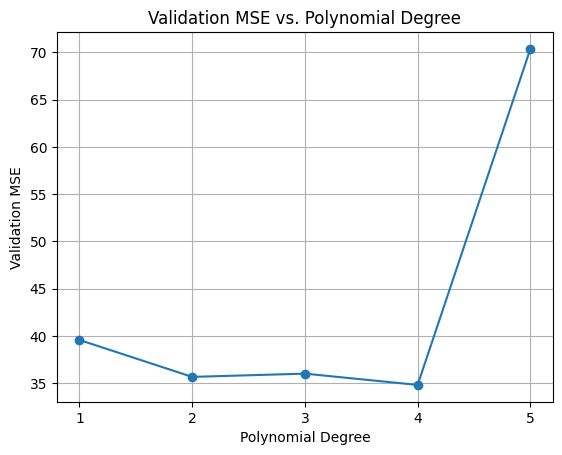

In [20]:
plt.plot(degrees, val_mses, marker='o')
plt.xlabel("Polynomial Degree")
plt.ylabel("Validation MSE")
plt.title("Validation MSE vs. Polynomial Degree")
plt.xticks(degrees)
plt.grid(True)
plt.show()

## 4 - Robust Model Selection with Cross-Validation

A single validation set can be effective, but its performance can be sensitive to which specific data points happen to end up in the training vs. validation split. A different random split could result in a different "best" hyperparameter.

**Cross-validation** is a more robust technique that mitigates this randomness. In k-fold cross-validation, the dataset is divided into k subsets or folds. The model is trained and evaluated k times, using a different fold as the validation set each time. Performance metrics from each fold are averaged to estimate the model's generalization performance more reliably.

![crossval](https://drive.google.com/uc?id=1i6IhODxbB4bX8O8MmmEpZ9EUsDCPUrI_)

### Manual Implementation of k-fold Cross-Validation

Let's see how we could manually implement k-fold cross-validation to evaluate a single model (e.g., a linear regression with the best polynomial degree we found earlier).

In [21]:
from sklearn.model_selection import KFold

# We use the full training data (X_train_val) for cross-validation
X_train_val = X_train_df.copy()

# Number of partitions/folds to divide the dataset into
k_folds = 8
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# This list will store the mean squared error for each fold.
val_mses = []

# Create the polynomial features for the best degree
poly = PolynomialFeatures(degree=best_degree, include_bias=False)
numerical_cols = scaled_train_df.columns
X_train_val_poly = poly.fit_transform(X_train_val[numerical_cols])
poly_feature_names = poly.get_feature_names_out(numerical_cols)
X_train_val_poly_df = pd.DataFrame(X_train_val_poly, columns=poly_feature_names, index=X_train_val.index)

# Combine with one-hot encoded features
ohe_cols = ohe_train_df.columns
X_train_val_full = pd.concat([X_train_val_poly_df, X_train_val[ohe_cols]], axis=1)


# BEGIN SOLUTION
# Iterate over each fold
for train_index, val_index in kf.split(X_train_val_full):
    # Get the training and validation sets for this fold
    X_train_fold, X_val_fold = X_train_val_full.iloc[train_index], X_train_val_full.iloc[val_index]
    y_train_fold, y_val_fold = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

    # Initialize and train a linear regression model
    model = LinearRegression()
    model.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold and compute MSE
    y_hat_val_fold = model.predict(X_val_fold)
    mse = mean_squared_error(y_val_fold, y_hat_val_fold)
    val_mses.append(mse)
# END SOLUTION
# BEGIN STUDENT
# # Iterate over each fold
# for train_index, val_index in kf.split(X_train_val_full):
#     # YOUR CODE HERE
#     # 1. Get the training and validation sets for this fold
#     # 2. Initialize and train a linear regression model
#     # 3. Predict on the validation fold and compute MSE
#     # 4. Append the MSE to the val_mses list
#     pass
# END STUDENT

# Calculate the average mean squared error across all folds.
avg_mse = np.mean(val_mses)

# Print the result
print(f"MSE for each fold: {np.round(val_mses, 2)}")
print(f"Average MSE from manual k-fold CV: {avg_mse:.2f}")

MSE for each fold: [4.118000e+01 2.580000e+01 5.862000e+01 2.842000e+01 4.299000e+01
 7.117000e+01 3.573169e+04 3.643000e+01]
Average MSE from manual k-fold CV: 4504.54


> **Question:** When we manually implemented cross-validation with `KFold`, we set `shuffle=True`. Why is shuffling the data before splitting it into folds often important?

### K-fold Cross-Validation with scikit-learn

Manually implementing cross-validation is great for understanding, but `scikit-learn` provides much easier ways to do it. The `cross_val_score` function is perfect for this. Let's use it to find the best polynomial degree again, but this time with the robustness of cross-validation.

In [22]:
from sklearn.model_selection import cross_val_score

degrees = [1, 2, 3, 4, 5]
mean_cv_scores = []
std_cv_scores = []

# We use the full training data (X_train_val) for cross-validation
X_train_val = X_train_df.copy()

for degree in degrees:
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    numerical_cols = scaled_train_df.columns
    X_train_val_poly = poly.fit_transform(X_train_val[numerical_cols])
    poly_feature_names = poly.get_feature_names_out(numerical_cols)
    X_train_val_poly_df = pd.DataFrame(X_train_val_poly, columns=poly_feature_names, index=X_train_val.index)

    # Combine with one-hot encoded features
    ohe_cols = ohe_train_df.columns
    X_train_val_full = pd.concat([X_train_val_poly_df, X_train_val[ohe_cols]], axis=1)

    # Initialize a linear regression model
    model = LinearRegression()

    # Perform k-fold cross-validation
    # We use 'neg_mean_squared_error' because scoring functions in sklearn are maximized.
    # By maximizing negative MSE, we are minimizing MSE.
    cv_scores = cross_val_score(model, X_train_val_full, y_train_val, cv=k_folds, scoring='neg_mean_squared_error')

    # Store the mean of the negative MSE scores (and make it positive)
    mean_cv_scores.append(-np.mean(cv_scores))
    std_cv_scores.append(np.std(cv_scores))

# Find the best degree from cross-validation
best_degree_cv = degrees[np.argmin(mean_cv_scores)]

print(f"Mean CV MSEs for each degree: {np.round(mean_cv_scores, 2)}")
print(f"Best polynomial degree from CV: {best_degree_cv}")

Mean CV MSEs for each degree: [4.4640000e+01 4.3390000e+01 3.5140000e+01 1.9090000e+02 1.1064927e+05]
Best polynomial degree from CV: 3


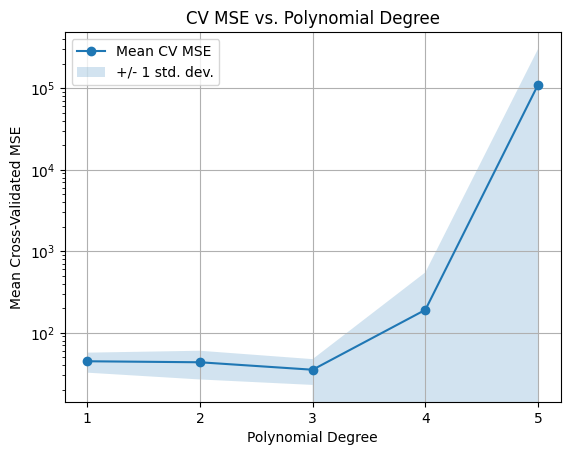

In [23]:
mean_cv_scores = np.array(mean_cv_scores)
std_cv_scores = np.array(std_cv_scores)

plt.plot(degrees, mean_cv_scores, marker='o', label="Mean CV MSE")
plt.fill_between(degrees, np.maximum(0, mean_cv_scores - std_cv_scores), mean_cv_scores + std_cv_scores, alpha=0.2, label="+/- 1 std. dev.")
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Cross-Validated MSE")
plt.title("CV MSE vs. Polynomial Degree")
plt.yscale('log')
plt.xticks(degrees)
plt.grid(True)
plt.legend()
plt.show()

> **Question:** In the plot of "CV MSE vs. Polynomial Degree," we used a logarithmic scale for the y-axis (`plt.yscale('log')`). What is the advantage of doing this? What features of the plot does it make easier to see?

Notice that with a more robust evaluation method, we've chosen a different "best" degree. This highlights the value of cross-validation over a single validation split.

### Using `cross_validate` for More Detailed Evaluation

The `cross_val_score` function is a convenient way to get a single performance metric. However, if you need more detailed information, such as training scores or multiple metrics at once, `cross_validate` is the tool to use. This can be very helpful for diagnosing issues like overfitting, by comparing training and validation performance.

Let's use it to evaluate our model with the `best_degree_cv`.

In [24]:
from sklearn.model_selection import cross_validate

# Create polynomial features with the best degree
poly = PolynomialFeatures(degree=best_degree_cv, include_bias=False)
numerical_cols = scaled_train_df.columns
X_train_val_poly = poly.fit_transform(X_train_val[numerical_cols])
poly_feature_names = poly.get_feature_names_out(numerical_cols)
X_train_val_poly_df = pd.DataFrame(X_train_val_poly, columns=poly_feature_names, index=X_train_val.index)
ohe_cols = ohe_train_df.columns
X_train_val_full = pd.concat([X_train_val_poly_df, X_train_val[ohe_cols]], axis=1)

# Initialize a linear regression model
model = LinearRegression()

# Define the metrics we want to compute
scoring = ['neg_mean_squared_error', 'r2']

# Perform cross-validation
cv_results = cross_validate(model, X_train_val_full, y_train_val, cv=k_folds, scoring=scoring, return_train_score=True)

# Print the results
print("Average Val MSE:", -np.mean(cv_results['test_neg_mean_squared_error']))
print("Average Val R^2:", np.mean(cv_results['test_r2']))
print("Average Train R^2:", np.mean(cv_results['train_r2']))

Average Val MSE: 35.13840184160525
Average Val R^2: 0.7550902420526964
Average Train R^2: 0.81959078617457


> **Gotcha!** The `cross_validate` function returns a dictionary where keys like `'test_neg_mean_squared_error'` and `'test_r2'` can be misleading. In this context, "test" refers to the score on the **validation fold** for each split, *not* the final, held-out test set that we created at the very beginning. It's a slightly confusing naming choice, but a very important distinction!

> **Question:** We used cross-validation on our training data (`X_train_val`) to find the best hyperparameter (the polynomial degree). Now that we have our "best" degree, why do we want to re-train a new model on the *entire* `X_train_val` dataset before evaluating it on the test set?
>
> **Answer Hint:** Think about what we are "throwing away" during each fold of cross-validation. We want to use as much data as possible for our final model.

### Final Model Evaluation

Now that we have found the best hyperparameter using cross-validation, we can train our final model on the *entire* training dataset (`X_train_val`) and evaluate its performance on the held-out test set.

In [25]:
# Create polynomial features with the best degree found by CV
poly_final = PolynomialFeatures(degree=best_degree_cv, include_bias=False)

# We use the full training data (X_train_val) and test data (X_test_df)
X_train_val = X_train_df.copy()
X_test = X_test_df.copy()

# Transform numerical features for both train and test sets
numerical_cols = scaled_train_df.columns
X_train_val_poly_final = poly_final.fit_transform(X_train_val[numerical_cols])
X_test_poly_final = poly_final.transform(X_test[numerical_cols])

# Get feature names
poly_feature_names_final = poly_final.get_feature_names_out(numerical_cols)

# Create DataFrames
X_train_val_poly_final_df = pd.DataFrame(X_train_val_poly_final, columns=poly_feature_names_final, index=X_train_val.index)
X_test_poly_final_df = pd.DataFrame(X_test_poly_final, columns=poly_feature_names_final, index=X_test.index)

# Combine with one-hot encoded features
ohe_cols = ohe_train_df.columns
X_train_val_final = pd.concat([X_train_val_poly_final_df, X_train_val[ohe_cols]], axis=1)
X_test_final = pd.concat([X_test_poly_final_df, X_test[ohe_cols]], axis=1)

# Fit the final linear regression model
final_model = LinearRegression()
# BEGIN SOLUTION
final_model.fit(X_train_val_final, y_train_val)

# # Evaluate on the train set
r2_train_final = final_model.score(X_train_val_final, y_train_val)
# Evaluate on the test set
r2_test_final = final_model.score(X_test_final, y_test)
# END SOLUTION
# BEGIN STUDENT
# # Fit the model on the entire training data
# ...
#
# # Evaluate on the train set
# r2_train_final = ...
# # Evaluate on the test set
# r2_test_final = ...
# END STUDENT
print(f"Final R^2 with polynomial degree {best_degree_cv}")
print(f"Test: {r2_train_final:.3f}")
print(f"Test: {r2_test_final:.3f}")

Final R^2 with polynomial degree 3
Test: 0.817
Test: 0.750


## 5 - Improving the Model with Feature Interactions and Regularization

### Adding Specific Interaction Terms

Our baseline polynomial model is a good start, but we might be able to improve it by adding interaction terms. Instead of adding all possible interactions (which would create too many features), we can select a few key predictors and generate their pairwise interactions. Let's select five features we believe are most important—`age`, `page_views`, `fpl_points`, `big_six_1`, and `new_signing_1`—and use `PolynomialFeatures` to cleanly generate all of their pairwise interaction terms.

In [26]:
# We use the full training data (X_train_val)
X_train_val = X_train_df.copy()
X_test = X_test_df.copy()

# Start with the feature set from our best polynomial model
X_train_complex = X_train_val_final.copy()
X_test_complex = X_test_final.copy()

# --- Create interaction terms ---
# Define the subset of features for which to create interactions
features_to_interact = ['age', 'page_views', 'big_six_1']
X_train_subset = X_train_val[features_to_interact]
X_test_subset = X_test[features_to_interact]

# Use PolynomialFeatures to generate pairwise interactions
interaction_transformer = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

# Fit on the training data subset and transform both train and test
train_interactions = interaction_transformer.fit_transform(X_train_subset)
test_interactions = interaction_transformer.transform(X_test_subset)

# Get the names of the new interaction features
interaction_names = interaction_transformer.get_feature_names_out(features_to_interact)

# Create DataFrames with the new features
train_interactions_df = pd.DataFrame(train_interactions, columns=interaction_names, index=X_train_val.index)
test_interactions_df = pd.DataFrame(test_interactions, columns=interaction_names, index=X_test.index)

# The output includes the original columns, so we select only the new interaction terms
# Interaction terms are those with a space in their name
interaction_only_names = [name for name in interaction_names if ' ' in name]
train_interaction_features = train_interactions_df[interaction_only_names]
test_interaction_features = test_interactions_df[interaction_only_names]

# Add the new interaction features to our complex model's feature set
X_train_complex = pd.concat([X_train_complex, train_interaction_features], axis=1)
X_test_complex = pd.concat([X_test_complex, test_interaction_features], axis=1)


print(f"Number of features in baseline model: {X_train_val_final.shape[1]}")
print(f"Number of features in complex model: {X_train_complex.shape[1]}")

Number of features in baseline model: 27
Number of features in complex model: 30


Our new feature set is massive and the features have a very wide range of scales. Before feeding them into a regularized model, we must scale them. This ensures that the regularization penalty is applied fairly to all features, regardless of their original units or magnitude. Without scaling, features with larger scales would be penalized more heavily, which is not what we want.

> **Question:** We are now scaling our entire feature set, which includes binary (0/1) features from one-hot encoding and their interactions. Does it make sense to 'scale' a feature that is already on a 0-1 scale? Why is it still a good practice in this context, especially before regularization?

In [27]:
# Scale the high-dimensional feature set
overfit_scaler = StandardScaler()
X_train_complex_scaled = overfit_scaler.fit_transform(X_train_complex)
X_test_complex_scaled = overfit_scaler.transform(X_test_complex)

Now let's fit a simple linear regression model to this more complex feature set.

In [28]:
# Fit a simple linear regression model
complex_model = LinearRegression()
complex_model.fit(X_train_complex_scaled, y_train_val)

# Check the scores
r2_train_complex = complex_model.score(X_train_complex_scaled, y_train_val)
r2_test_complex = complex_model.score(X_test_complex_scaled, y_test)

print(f"R^2 train (complex model) = {r2_train_complex:.3}")
print(f"R^2 test (complex model) = {r2_test_complex:.3}")

R^2 train (complex model) = 0.822
R^2 test (complex model) = 0.741


The added complexity has slightly increased the training R^2 but has hurt the test R^2. The gap between the train and test performance suggests our model is overfitting. This is a perfect scenario to apply regularization, which can help by penalizing large coefficients and simplifying the model.

> **Question:** $R^2$ scores can sometimes be negative! What is the interpretation of a negative $R^2$?

### Applying Regularization

**Regularization** is a technique used to combat overfitting by adding a penalty term to the loss function. This penalty discourages the model from learning overly complex patterns by shrinking the coefficient estimates towards zero.

#### Ridge Regression (L2 Penalty)

Ridge regression adds a penalty proportional to the square of the magnitude of the coefficients.

$$L_{\text{Ridge}} = \frac{1}{n} \sum_{i=1}^{n} \left|y_i - \beta^\top x_i \right|^2 + \lambda \sum_{j=1}^{p}\beta_j^2$$

The tuning parameter $\lambda$ (or `alpha` in scikit-learn) controls the strength of the penalty.

#### Lasso Regression (L1 Penalty)

Lasso regression adds a penalty proportional to the absolute value of the magnitude of the coefficients.

$$L_{\text{Lasso}} = \frac{1}{n} \sum_{i=1}^{n} \left|y_i - \beta^\top x_i \right|^2 + \lambda \sum_{j=1}^{p}|\beta_j|$$

A key feature of Lasso is that it can shrink some coefficients to be exactly zero, effectively performing feature selection.

> **Question:** Look at the penalty terms for Ridge and Lasso. Why is it crucial that our features are on a similar scale before applying regularization? What would happen if one feature had a much larger scale than the others?

> **Question:** Lasso is known for performing feature selection by forcing some coefficients to become exactly zero. Ridge, on the other hand, only shrinks them towards zero. In what practical scenario might you prefer Lasso over Ridge? When might Ridge be the better choice?

### Automated Hyperparameter Tuning with Cross-Validation

We can use `RidgeCV` and `LassoCV` to automatically find the best `alpha` hyperparameter using cross-validation and fit a regularized model to our overfit dataset.

> **Question:** When we set up `RidgeCV` and `LassoCV`, we provided a list of `alphas` created with `np.logspace`. Why is it common practice to search for hyperparameters like the regularization strength on a logarithmic scale rather than a linear one?

> **Gotcha!** The `RidgeCV` and `LassoCV` models will sort the list of alphas you provide them. This means that the `mse_path_` attribute on a fitted `LassoCV` model, which contains the MSE for each alpha, will be ordered according to the *sorted* alphas, not necessarily the order you provided them in.

In [29]:
# Set parameters for cross-validation
ridge_alphas = np.logspace(-2, 3, 100)
lasso_alphas = np.logspace(-3, 0, 100)
k = 8

# These CV models refit on the full training data
# using the best alpha found during cross-validation!
ridge = RidgeCV(alphas=ridge_alphas,
                cv=k).fit(X_train_complex_scaled, y_train_val)
lasso = LassoCV(alphas=lasso_alphas,
                cv=k,
                max_iter=10000,
                tol=0.0001).fit(X_train_complex_scaled, y_train_val)

# Best alphas & test scores
print("[Test R^2]")
# BEGIN SOLUTION
ridge_a = ridge.alpha_
print(f'Ridge /w alpha={ridge_a:.5f}: {ridge.score(X_test_complex_scaled, y_test):.3}')
# END SOLUTION
# BEGIN STUDENT
# # Get the best alpha from the fitted RidgeCV model
# ridge_a = ...
# # Print the score on the test set
# print(f'Ridge /w alpha={ridge_a:.5f}: {...:.3}')
# END STUDENT

lasso_a = lasso.alpha_
print(f'LASSO /w alpha={lasso_a:.5f}: {lasso.score(X_test_complex_scaled, y_test):.3}')

[Test R^2]
Ridge /w alpha=0.23101: 0.751
LASSO /w alpha=0.09326: 0.768


> **Question:** You may sometimes see a `ConvergenceWarning` when running the Lasso model. What does this warning mean? If you see it, does it mean your model is unusable? What parameters could you adjust to try to resolve it? RidgeCV doesn't have these parameters. Why not?

> **Gotcha!** The `LassoCV` and `RidgeCV` objects are convenient because they not only find the best `alpha` but also automatically re-fit a final model on the *entire* training dataset using that `alpha`. Why is this final re-fitting step, which `cross_val_score` does *not* do, so important for building the best possible model?

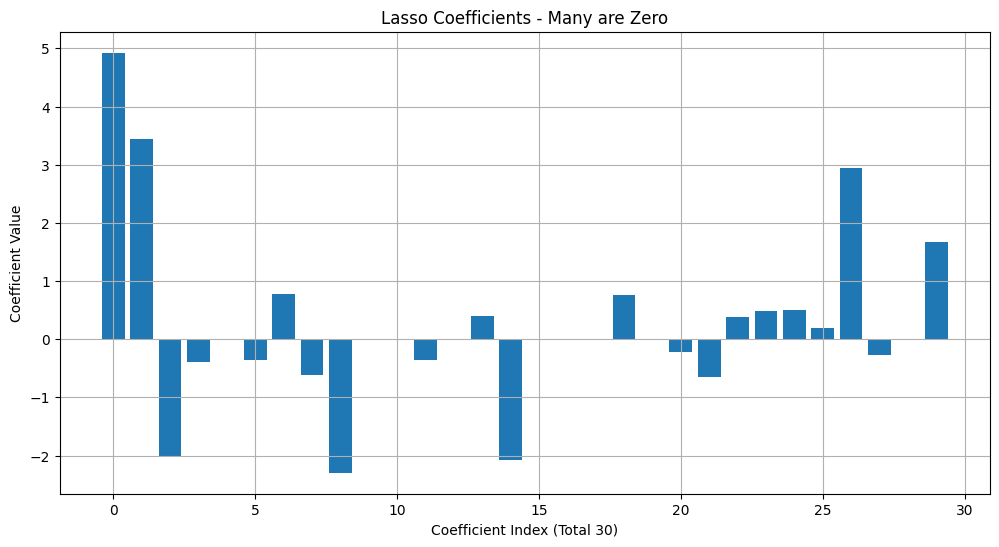

Total number of features: 30
Number of features with non-zero coefficients: 21


In [30]:
n_coefs = len(lasso.coef_)
plt.figure(figsize=(12, 6))
plt.bar(range(n_coefs), lasso.coef_)
plt.xlabel(f"Coefficient Index (Total {n_coefs})")
plt.ylabel("Coefficient Value")
plt.title("Lasso Coefficients - Many are Zero")
plt.grid(True)
plt.show()

print(f"Total number of features: {n_coefs}")
print(f"Number of features with non-zero coefficients: {np.sum(lasso.coef_ != 0)}")

> **Question:** Now that our features have been scaled, how does the interpretation of a regression coefficient ($\beta_j$) change?
>
> **Question:** The coefficients we see are for the scaled features. If we needed to report the model in terms of the original feature units (e.g., for every 1-year increase in age, market value changes by X), how could we use our fitted `StandardScaler` object (`overfit_scaler`) to recover the original-scale coefficients?

### Visualizing Regularization Performance

Let's visualize how the cross-validated mean squared error changes as we vary the regularization parameter `alpha`. This helps us understand how sensitive the model is to the choice of `alpha` and confirms that our `RidgeCV` and `LassoCV` picked a reasonable value.

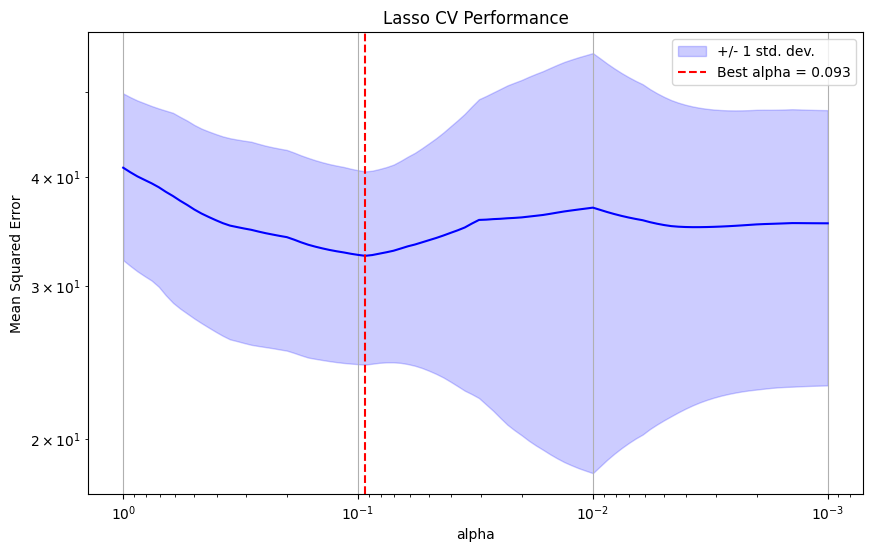

In [31]:
# For Lasso, the mse_path_ attribute stores the MSE for each alpha and fold
lasso_mses = np.mean(lasso.mse_path_, axis=1)
lasso_stds = np.std(lasso.mse_path_, axis=1)

plt.figure(figsize=(10, 6))

plt.plot(lasso.alphas_, lasso_mses, 'b-')
plt.fill_between(lasso.alphas_, np.maximum(0, lasso_mses - lasso_stds), lasso_mses + lasso_stds, color='b', alpha=0.2, label="+/- 1 std. dev.")
plt.axvline(lasso.alpha_, color='r', linestyle='--', label=f'Best alpha = {lasso.alpha_:.3f}')

plt.xscale('log')
plt.gca().invert_xaxis() # Alphas in LassoCV are in descending order
plt.xlabel('alpha')
plt.ylabel('Mean Squared Error')
plt.title('Lasso CV Performance')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

### Coefficient Path (Trace Plots)

A great way to visualize the effect of regularization is to plot the value of each coefficient as a function of the regularization parameter `alpha`. This is often called a "trace plot" or "coefficient path".

- For **Ridge**, we expect coefficients to shrink smoothly towards zero as `alpha` increases.
- For **Lasso**, we expect coefficients to shrink as well, but some will be forced to *exactly* zero, effectively removing them from the model.

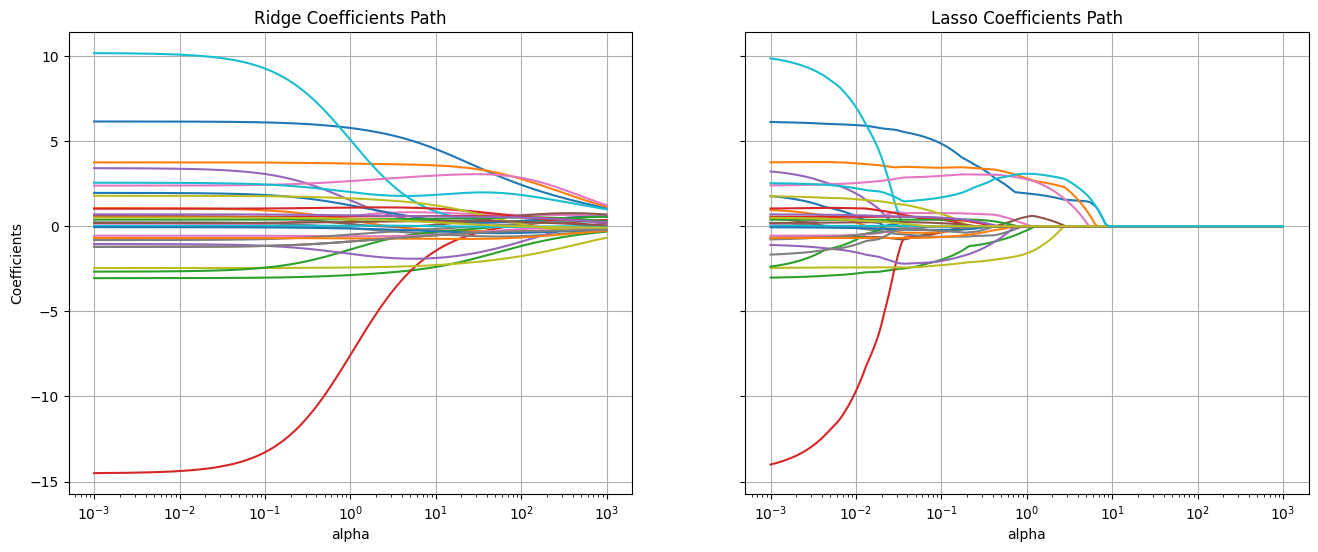

In [32]:
# We'll use the same overfitted data
X = X_train_complex_scaled
y = y_train_val

# Alphas to iterate over
alphas = np.logspace(-3, 3, 200)

# Store coefficients
ridge_coefs = []
lasso_coefs = []

for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=True)
    ridge.fit(X, y)
    ridge_coefs.append(ridge.coef_)

    lasso = Lasso(alpha=a, fit_intercept=True, max_iter=10000, tol=0.0001)
    lasso.fit(X, y)
    lasso_coefs.append(lasso.coef_)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Ridge Trace Plot
ax1.plot(alphas, ridge_coefs)
ax1.set_xscale('log')
ax1.set_xlabel('alpha')
ax1.set_ylabel('Coefficients')
ax1.set_title('Ridge Coefficients Path')
ax1.grid(True)

# Lasso Trace Plot
ax2.plot(alphas, lasso_coefs)
ax2.set_xscale('log')
ax2.set_xlabel('alpha')
ax2.set_title('Lasso Coefficients Path')
ax2.grid(True)

plt.show()

Success! By applying regularization, we were able to control the complexity of the model with many features, leading to much better performance on the test set. Both Ridge and Lasso significantly improved the R^2 score compared to the simple linear regression model.